In [2]:
import itertools
import math
import os
import gsd.hoomd
import hoomd
import numpy
import warnings
import fresnel
import IPython
import packaging.version 
import matplotlib
import io 
import PIL
import freud
import matplotlib.pyplot as plt

%matplotlib inline 
matplotlib.style.use('ggplot')
import matplotlib_inline

matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

In [3]:
device = fresnel.Device()
tracer = fresnel.tracer.Path(device=device, w=300, h=300)

def render(snapshot):

    vertices = [
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
    ]

    L = snapshot.configuration.box[0]
    scene = fresnel.Scene(device)

    geometry = fresnel.geometry.Polygon(
        scene, vertices = vertices, N=len(snapshot.particles.position)
    )
    geometry.material = fresnel.material.Material(
        color=fresnel.color.linear([100 / 255, 216 / 255, 230 / 255]), roughness=0.2
    )
    positions = numpy.array(snapshot.particles.position)[:, :2]
    geometry.position[:] = positions

    orientations = numpy.array(snapshot.particles.orientation)
    angles = 2 * numpy.arctan2(orientations[:, 3], orientations[:, 0])
    geometry.angle[:] = angles
    
    geometry.outline_width = 0.01

    fresnel.geometry.Box(scene, [L, L, 0.1, 0, 0, 0], box_radius=0.02)

    scene.lights = [
        fresnel.light.Light(direction=(0, 0, 1), color=(0.8, 0.8, 0.8), theta=math.pi),
        fresnel.light.Light(
            direction=(1, 1, 1), color=(1.1, 1.1, 1.1), theta=math.pi / 3
        ),
    ]
    scene.camera = fresnel.camera.Orthographic(
        position=(0, 0, 10), look_at=(0, 0, 0), up=(0, 1, 0), height=L * 1.1
    )
    scene.background_alpha = 1
    scene.background_color = (1, 1, 1)
    return IPython.display.Image(tracer.sample(scene, samples=500)._repr_png_())

In [ ]:
m = 5
N_particles = m**2
spacing = 2.1
K = math.ceil(N_particles ** (1 / 2))
L = K * spacing
x = numpy.linspace(-L / 2, L / 2, K, endpoint=False)
position = [(px, py, 0) for px, py in itertools.product(x, x)][:N_particles]
orientation = [(1, 0, 0, 0)] * N_particles

frame = gsd.hoomd.Frame()
frame.particles.N = N_particles
frame.particles.position = position[0:N_particles]
frame.particles.orientation = orientation[0:N_particles]
frame.particles.typeid = [0] * N_particles
frame.configuration.box = [L, L, 0, 0, 0, 0]
frame.particles.types = ['Squares']


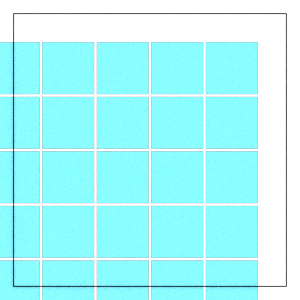

In [21]:
render(frame)

In [22]:
fn = os.path.join(os.getcwd(), 'lattice_sq.gsd')
![ -e "$fn" ] && rm "$fn"

with gsd.hoomd.open(name='lattice_sq.gsd', mode='x') as f:
    f.append(frame)

In [67]:
cpu = hoomd.device.CPU()

In [73]:
simulation = hoomd.Simulation(device=cpu, seed=20)
simulation.create_state_from_gsd(filename='lattice_sq.gsd')

In [74]:
fn = os.path.join(os.getcwd(), 'trajectory_expansion.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_expansion.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [75]:
def expand(simulation, target_volume_fraction, s, ramp_steps, run_steps):
    mc = hoomd.hpmc.integrate.ConvexPolygon()
    mc.shape['Squares'] = dict(
        vertices = [
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
        ]
    )
    simulation.operations.integrator = mc

    volume_particle = s ** 2
    target_rho = target_volume_fraction / volume_particle
    final_rho = target_rho
    final_volume = simulation.state.N_particles / final_rho
    
    inverse_volume_ramp = hoomd.variant.box.InverseVolumeRamp(
        initial_box=simulation.state.box,
        final_volume=final_volume,
        t_start=simulation.timestep,
        t_ramp=ramp_steps,
    )

    box_resize = hoomd.update.BoxResize(
        trigger=hoomd.trigger.Periodic(10),
        box=inverse_volume_ramp,
    )
    simulation.operations.updaters.append(box_resize)

    tune = hoomd.hpmc.tune.MoveSize.scale_solver(
        moves=['d', 'a'],
        target=0.2,
        max_translation_move=0.025,
        max_rotation_move=0.2,
        trigger=hoomd.trigger.And(
            [hoomd.trigger.Periodic(100), hoomd.trigger.Before(simulation.timestep + 5000)]
        ),
    )
    simulation.operations.tuners.append(tune)
    simulation.run(run_steps)

    gsd_writer.flush()
    
    return mc.overlaps  

In [76]:
expand(simulation=simulation, target_volume_fraction=0.01, s=2, ramp_steps=20000, run_steps=20001)

0

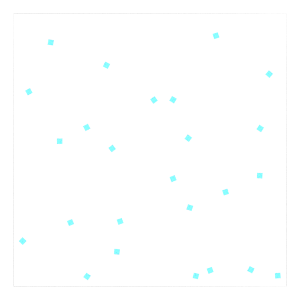

In [77]:
render(simulation.state.get_snapshot())

In [78]:
del(simulation)

In [79]:
traj_exp = gsd.hoomd.open('trajectory_expansion.gsd')
len(traj_exp)

200

In [166]:
simulation = hoomd.Simulation(device=cpu, seed=17)
simulation.create_state_from_gsd(filename='trajectory_expansion.gsd')

In [167]:
fn = os.path.join(os.getcwd(), 'trajectory_compress.gsd')
![ -e "$fn" ] && rm "$fn"

gsd_writer = hoomd.write.GSD(
    filename='trajectory_compress.gsd', trigger=hoomd.trigger.Periodic(100), mode='xb'
)
simulation.operations.writers.append(gsd_writer)

In [168]:
def compress(simulation, target_volume_fraction, s, ramp_steps, run_steps):
    mc = hoomd.hpmc.integrate.ConvexPolygon()
    mc.shape['Squares'] = dict(
        vertices = [
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
        ]
    )
    simulation.operations.integrator = mc

    volume_particle = s ** 2
    target_rho = target_volume_fraction / volume_particle
    final_rho = target_rho
    final_volume = simulation.state.N_particles / final_rho
    
    inverse_volume_ramp = hoomd.variant.box.InverseVolumeRamp(
        initial_box=simulation.state.box,
        final_volume=final_volume,
        t_start=simulation.timestep,
        t_ramp=ramp_steps,
    )

    box_resize = hoomd.update.BoxResize(
        trigger=hoomd.trigger.Periodic(10),
        box=inverse_volume_ramp,
    )
    simulation.operations.updaters.append(box_resize)

    tune = hoomd.hpmc.tune.MoveSize.scale_solver(
        moves=['d', 'a'],
        target=0.2,
        max_translation_move=0.025,
        max_rotation_move=0.2,
        trigger=hoomd.trigger.And(
            [hoomd.trigger.Periodic(100), hoomd.trigger.Before(simulation.timestep + 5000)]
        ),
    )
    simulation.operations.tuners.append(tune)
    simulation.run(run_steps)

    return mc.overlaps  

In [169]:
compress(simulation=simulation, target_volume_fraction=0.99, s=2, ramp_steps=40000, run_steps=40001)

4

In [170]:
def run_sim(simulation, steps):
    mc = hoomd.hpmc.integrate.ConvexPolygon()
    mc.shape['Squares'] = dict(
        vertices = [
        (-1, -1),
        (1, -1),
        (1, 1),
        (-1, 1)
        ]
    )
    simulation.operations.integrator = mc

    simulation.run(steps)

    return mc.overlaps  


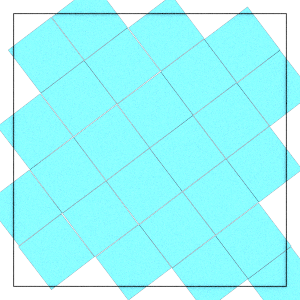

In [171]:
render(simulation.state.get_snapshot())

In [172]:
run_sim(simulation, steps=10e5)

0

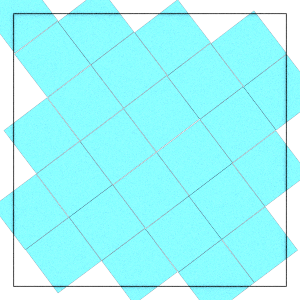

In [173]:
render(simulation.state.get_snapshot())

In [132]:
vf_c = (simulation.state.N_particles * 2**2) / simulation.state.box.volume
vf_c

0.99

In [134]:
gsd_writer.flush()

In [142]:
################
################
################
################
################
################
################
################
################
################

In [135]:
traj_exp = gsd.hoomd.open('trajectory_expansion.gsd')
len(traj_exp)

200

In [137]:
traj_cmp = gsd.hoomd.open('trajectory_compress.gsd')
len(traj_cmp)

10400

In [140]:
solid = freud.order.SolidLiquid(l=6, q_threshold=0.7, solid_threshold=6)
is_solid = []
for frame in traj_exp:
    solid.compute(
        system=(frame.configuration.box, frame.particles.position),
        neighbors=dict(mode='nearest', num_neighbors=12),
    )
    is_solid.append(solid.num_connections > solid.solid_threshold)

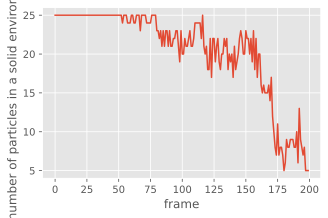

In [141]:
fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
num_solid = numpy.array([numpy.sum(a) for a in is_solid])
ax.plot(num_solid)
ax.set_xlabel('frame')
ax.set_ylabel('number of particles in a solid environment')
fig

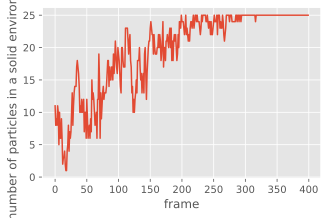

In [176]:
solid = freud.order.SolidLiquid(l=6, q_threshold=0.7, solid_threshold=6)
is_solid = []

for i, frame in enumerate(traj_cmp):
    if i >= 400:
        break
    solid.compute(
        system=(frame.configuration.box, frame.particles.position),
        neighbors=dict(mode='nearest', num_neighbors=12),
    )
    is_solid.append(solid.num_connections > solid.solid_threshold)

fig = matplotlib.figure.Figure(figsize=(5, 3.09))
ax = fig.add_subplot()
num_solid = numpy.array([numpy.sum(a) for a in is_solid])
ax.plot(num_solid)
ax.set_xlabel('frame')
ax.set_ylabel('number of particles in a solid environment')
fig
